# Promotion Probability Conditional on League Points Tuples
Import Packages

In [51]:
import numpy as np
from dataclasses import dataclass
from itertools import permutations
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from typing import Iterable, Tuple, Dict, List, Optional, Set

Load Team Season Kick Success Rates and Weibull Model Parameters

In [36]:
# Kick Rate
kickrate_npz_path = r"C:\Users\olwyn\OneDrive\Desktop\Working Models\Promotion Probability\teamSeasonKickrate.npz"
with np.load(kickrate_npz_path, allow_pickle=True) as z:
    team_season_keys = z["team_season_keys"]
    team_season_vals = z["team_season_vals"]
team_season_to_kickrate = dict(zip(map(str, team_season_keys), team_season_vals.astype(float)))

# Weibull parameters
weibull_npz_path = r"C:\Users\olwyn\OneDrive\Desktop\Working Models\Promotion Probability\weibullParams.npz"
with np.load(weibull_npz_path, allow_pickle=True) as z:
    alpha_try   = float(z["alpha_try"])
    alpha_goal  = float(z["alpha_goal"])
    lam         = z["lam"].astype(float)
    gamma_try   = float(z["gamma_try"])
    gamma_goal  = float(z["gamma_goal"])

    A_try   = z["A_try"].astype(float)
    D_try   = z["D_try"].astype(float)
    A_goal  = z["A_goal"].astype(float)
    D_goal  = z["D_goal"].astype(float)

    beta_try  = z["beta_try"].astype(float)
    beta_goal = z["beta_goal"].astype(float)

    team_names = np.array([str(t) for t in z["team_names"]], dtype=object)
    n_teams    = int(z["n_teams"])

params_hat = {
    "alpha_try": alpha_try,
    "alpha_goal": alpha_goal,
    "lam": lam,
    "gamma_try": gamma_try,
    "gamma_goal": gamma_goal,
    "A_try": A_try,
    "D_try": D_try,
    "A_goal": A_goal,
    "D_goal": D_goal,
    "beta_try": beta_try,
    "beta_goal": beta_goal,
}

Load Current League Table and Remaining Fixtures

In [38]:
league_table = {
    "Old Wesley_2526": {"PTS": 51, "DIFF": 130},
    "Dublin University_2526": {"PTS": 44, "DIFF": 89},
    "Instonians_2526": {"PTS": 44, "DIFF": 88},
    "Highfield_2526": {"PTS": 40, "DIFF": 31},
    "City of Armagh_2526": {"PTS": 36, "DIFF": 12},
    "Garryowen_2526": {"PTS": 32, "DIFF": 14},
    "University College Cork_2526": {"PTS": 30, "DIFF": -22},
    "Blackrock College RFC_2526": {"PTS": 27, "DIFF": -52},
    "Naas_2526": {"PTS": 26, "DIFF": -71},
    "Queens University Belfast RFC_2526": {"PTS": 14, "DIFF": -219},
}
remaining_fixtures = [
    ("City of Armagh_2526", "Blackrock College RFC_2526"),
    ("Instonians_2526", "Dublin University_2526"),
    ("Naas_2526", "Queens University Belfast RFC_2526"),
    ("Old Wesley_2526", "Garryowen_2526"),
    ("University College Cork_2526", "Highfield_2526"),

    ("Dublin University_2526", "University College Cork_2526"),
    ("Garryowen_2526", "Blackrock College RFC_2526"),
    ("Highfield_2526", "Naas_2526"),
    ("Old Wesley_2526", "Instonians_2526"),
    ("Queens University Belfast RFC_2526", "City of Armagh_2526"),

    ("Blackrock College RFC_2526", "Queens University Belfast RFC_2526"),
    ("City of Armagh_2526", "Highfield_2526"),
    ("Instonians_2526", "Garryowen_2526"),
    ("Naas_2526", "Dublin University_2526"),
    ("University College Cork_2526", "Old Wesley_2526"),

    ("Instonians_2526", "University College Cork_2526"),
    ("Dublin University_2526", "City of Armagh_2526"),
    ("Garryowen_2526", "Queens University Belfast RFC_2526"),
    ("Highfield_2526", "Blackrock College RFC_2526"),
    ("Old Wesley_2526", "Naas_2526"),

    ("Blackrock College RFC_2526", "Dublin University_2526"),
    ("City of Armagh_2526", "Old Wesley_2526"),
    ("Naas_2526", "Instonians_2526"),
    ("Queens University Belfast RFC_2526", "Highfield_2526"),
    ("University College Cork_2526", "Garryowen_2526"),
]

In [ ]:
SEASON_TAG = "_2526"

full_team_names = np.array([str(t) for t in team_names], dtype=object)

idx_2526 = np.array(
    [i for i, t in enumerate(full_team_names) if t.endswith(SEASON_TAG)],
    dtype=np.int32
)

team_names_2526 = full_team_names[idx_2526].tolist()

team_to_idx = {team: i for i, team in enumerate(team_names_2526)}
idx_to_team = {i: team for team, i in team_to_idx.items()}
n_teams_2526 = len(team_names_2526)

# Slice team-effect arrays
A_try_2526  = A_try[idx_2526]
D_try_2526  = D_try[idx_2526]
A_goal_2526 = A_goal[idx_2526]
D_goal_2526 = D_goal[idx_2526]

# Rebuild params_hat with sliced arrays
params_hat = {
    "alpha_try": alpha_try,
    "alpha_goal": alpha_goal,
    "lam": lam,
    "gamma_try": gamma_try,
    "gamma_goal": gamma_goal,
    "A_try": A_try_2526,
    "D_try": D_try_2526,
    "A_goal": A_goal_2526,
    "D_goal": D_goal_2526,
    "beta_try": beta_try,
    "beta_goal": beta_goal,
}

print("Teams in 2526 slice:", n_teams_2526)
print("DU idx:", team_to_idx.get("Dublin University_2526", None))
print("Queens idx:", team_to_idx.get("Queens University Belfast RFC_2526", None))


Single Game Simulator

In [ ]:
PTS_TRY  = 5
PTS_CONV = 2
PTS_GOAL = 3  
HAZ_ORDER = ["home_try", "away_try", "home_goal", "away_goal"]
R = 81
MARGIN_MIN = -40
MARGIN_MAX = 40

def _clip_margin_to_idx(margin: float) -> int:
    m = int(round(margin))
    if m < MARGIN_MIN:
        m = MARGIN_MIN
    elif m > MARGIN_MAX:
        m = MARGIN_MAX
    return m - MARGIN_MIN
def compute_league_points(
    home_pts: np.ndarray,
    away_pts: np.ndarray,
    home_tries: np.ndarray,
    away_tries: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Rules:
      - Win=4, Draw=2, Loss=0
      - +1 for losing by <=7
      - +1 for scoring >=4 tries
    """
    home_pts = np.asarray(home_pts)
    away_pts = np.asarray(away_pts)
    home_tries = np.asarray(home_tries)
    away_tries = np.asarray(away_tries)

    home_win = home_pts > away_pts
    away_win = away_pts > home_pts
    draw = home_pts == away_pts

    lp_home = np.zeros_like(home_pts, dtype=np.int32)
    lp_away = np.zeros_like(away_pts, dtype=np.int32)

    lp_home[home_win] = 4
    lp_away[away_win] = 4
    lp_home[draw] = 2
    lp_away[draw] = 2

    margin = np.abs(home_pts - away_pts)
    lp_home[(away_win) & (margin <= 7)] += 1
    lp_away[(home_win) & (margin <= 7)] += 1

    lp_home[home_tries >= 4] += 1
    lp_away[away_tries >= 4] += 1

    return lp_home, lp_away

In [40]:
def _draw_weibull_residual_time(alpha: float, rate: float, rng: np.random.Generator, age: float) -> float:
    """
    Residual time until event for a Weibull process with shape alpha and 'rate' parameterization
    consistent with your existing code, conditional on having already survived `age` minutes.

    If age=0, this reduces to your usual draw.
    """
    rate = float(max(rate, 1e-12))
    age = float(max(age, 0.0))
    E = float(rng.exponential(1.0))
    return (age**alpha + E / rate) ** (1.0 / alpha) - age
def _get_conv_rate(team_season: str, team_season_to_kickrate: dict, *, default: float = 0.72) -> float:
    """
    Return the conversion success probability for a given team-season.

    If not found, fall back to:
      - season-average (if we can compute it), else
      - `default`.

    Notes:
      - team_season is like "Dublin University_2526"
      - team_season_to_kickrate maps str -> float
    """
    if team_season in team_season_to_kickrate:
        p = float(team_season_to_kickrate[team_season])
        return float(np.clip(p, 0.01, 0.99))

    # fallback: season average for that season tag (e.g. "_2526")
    season_tag = "_" + team_season.split("_")[-1]  # "_2526"
    vals = [float(v) for k, v in team_season_to_kickrate.items() if str(k).endswith(season_tag)]
    if len(vals) > 0:
        p = float(np.mean(vals))
        return float(np.clip(p, 0.01, 0.99))

    return float(np.clip(default, 0.01, 0.99))
def simulate_one_match(
    params: dict,
    home_u: int,
    away_u: int,
    home_team_season: str,
    away_team_season: str,
    team_season_to_kickrate: dict,
    rng: np.random.Generator,
    end_time: float = 80.0,
    # -------- new: in-game state ----------
    t0: float = 0.0,
    home_pts0: int = 0,
    away_pts0: int = 0,
    home_tries0: int = 0,
    away_tries0: int = 0,
    last_hazard_time: float | None = None,  # minutes; if None, assume fresh spell at t0
) -> tuple[int, int, int, int]:
    """
    Returns: (home_pts, away_pts, home_tries, away_tries)

    In-game usage:
      - set t0 to current time (mins)
      - set score/tries to current values
      - set last_hazard_time to the minute of the last scoring event (spell reset)
        (then spell age = t0 - last_hazard_time)

    Notes:
      - Half-time/full-time boundaries: your existing censoring logic is preserved.
      - After any scoring event occurs in simulation, spell age resets to 0 (last_hazard_time = t).
    """
    alpha_try = float(params["alpha_try"])
    alpha_goal = float(params["alpha_goal"])
    lam = np.asarray(params["lam"], dtype=float)  # [HT, AT, HG, AG]
    gamma_try = float(params["gamma_try"])
    gamma_goal = float(params["gamma_goal"])

    A_try = np.asarray(params["A_try"], dtype=float)
    D_try = np.asarray(params["D_try"], dtype=float)
    A_goal = np.asarray(params["A_goal"], dtype=float)
    D_goal = np.asarray(params["D_goal"], dtype=float)

    beta_try = np.asarray(params["beta_try"], dtype=float)    # length 81
    beta_goal = np.asarray(params["beta_goal"], dtype=float)  # length 81

    p_conv_home = _get_conv_rate(home_team_season, team_season_to_kickrate)
    p_conv_away = _get_conv_rate(away_team_season, team_season_to_kickrate)

    # ---------- initialize state ----------
    t = float(t0)
    home_pts = int(home_pts0)
    away_pts = int(away_pts0)
    home_tries = int(home_tries0)
    away_tries = int(away_tries0)
    margin = home_pts - away_pts

    # if last_hazard_time not provided, assume spell just started at t0
    if last_hazard_time is None:
        last_hazard_time = t
    last_hazard_time = float(last_hazard_time)

    while t < end_time - 1e-9:
        next_boundary = 40.0 if t < 40.0 else 80.0
        dt_max = next_boundary - t
        if dt_max <= 1e-9:
            t = next_boundary
            # treat boundary as a restart point (new spell)
            last_hazard_time = t
            continue

        # current spell age (mins since last scoring event / restart)
        age = max(0.0, t - last_hazard_time)

        idx_home = _clip_margin_to_idx(margin)
        idx_away = (R - 1) - idx_home

        f_try_home = beta_try[idx_home]
        f_try_away = beta_try[idx_away]
        f_goal_home = beta_goal[idx_home]
        f_goal_away = beta_goal[idx_away]

        eta_HT = gamma_try + (A_try[home_u] - D_try[away_u]) + f_try_home
        eta_AT = -gamma_try + (A_try[away_u] - D_try[home_u]) + f_try_away
        eta_HG = gamma_goal + (A_goal[home_u] - D_goal[away_u]) + f_goal_home
        eta_AG = -gamma_goal + (A_goal[away_u] - D_goal[home_u]) + f_goal_away

        rate_HT = lam[0] * np.exp(eta_HT)
        rate_AT = lam[1] * np.exp(eta_AT)
        rate_HG = lam[2] * np.exp(eta_HG)
        rate_AG = lam[3] * np.exp(eta_AG)

        # residual draws conditional on surviving `age` minutes in the current spell
        T_HT = _draw_weibull_residual_time(alpha_try,  rate_HT, rng, age)
        T_AT = _draw_weibull_residual_time(alpha_try,  rate_AT, rng, age)
        T_HG = _draw_weibull_residual_time(alpha_goal, rate_HG, rng, age)
        T_AG = _draw_weibull_residual_time(alpha_goal, rate_AG, rng, age)

        Ts = np.array([T_HT, T_AT, T_HG, T_AG], dtype=float)
        k = int(np.argmin(Ts))
        dt = float(Ts[k])

        # censor to boundary
        if dt >= dt_max:
            t = next_boundary
            last_hazard_time = t  # boundary restart
            continue

        # event occurs
        t = t + dt
        ev = HAZ_ORDER[k]

        if ev == "home_try":
            home_pts += PTS_TRY
            home_tries += 1
            if rng.random() < p_conv_home:
                home_pts += PTS_CONV

        elif ev == "away_try":
            away_pts += PTS_TRY
            away_tries += 1
            if rng.random() < p_conv_away:
                away_pts += PTS_CONV

        elif ev == "home_goal":
            home_pts += PTS_GOAL

        elif ev == "away_goal":
            away_pts += PTS_GOAL

        margin = home_pts - away_pts

        # restart spell clock after a scoring event
        last_hazard_time = t

    return home_pts, away_pts, home_tries, away_tries

Pregame Simulations

In [41]:
def rank_teams_coinflip(pts: np.ndarray, diff: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    pts = np.asarray(pts)
    diff = np.asarray(diff)
    n = pts.size
    order = np.lexsort((-diff, -pts))  # already best-to-worst because of negatives
    i = 0
    while i < n:
        j = i + 1
        while j < n and pts[order[j]] == pts[order[i]] and diff[order[j]] == diff[order[i]]:
            j += 1
        if j - i > 1:
            block = order[i:j].copy()
            rng.shuffle(block)
            order[i:j] = block
        i = j
    return order
def simulate_full_season_tables(*, teams_sorted: list[str], league_table: dict, remaining_fixtures: list[tuple[str, str]], exclude_fixture: tuple[str, str] | None, params_hat: dict, team_to_idx: dict, team_season_to_kickrate: dict, n_sims: int = 500, seed: int = 7, end_time: float = 80.0) -> tuple[list[str], np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    n_teams = len(teams_sorted)
    pts0 = np.array([league_table[t]["PTS"] for t in teams_sorted], dtype=np.int32)
    diff0 = np.array([league_table[t]["DIFF"] for t in teams_sorted], dtype=np.int32)
    fixtures = list(remaining_fixtures)
    def _same_fixture(a: tuple[str, str], b: tuple[str, str]) -> bool:
        return (a[0] == b[0] and a[1] == b[1]) or (a[0] == b[1] and a[1] == b[0])
    if exclude_fixture is not None:
        fixtures = [fx for fx in fixtures if not _same_fixture(fx, exclude_fixture)]
    pts_sim = np.empty((n_sims, n_teams), dtype=np.int32)
    diff_sim = np.empty((n_sims, n_teams), dtype=np.int32)
    for s in range(n_sims):
        pts_row = pts0.copy()
        diff_row = diff0.copy()
        for home, away in fixtures:
            hu = int(team_to_idx[home])
            au = int(team_to_idx[away])
            hp, ap, ht, at = simulate_one_match(params_hat, hu, au, home, away, team_season_to_kickrate, rng, end_time=end_time, t0=0.0, home_pts0=0, away_pts0=0, home_tries0=0, away_tries0=0, last_hazard_time=0.0)
            lp_h, lp_a = compute_league_points(np.array([hp], dtype=np.int32), np.array([ap], dtype=np.int32), np.array([ht], dtype=np.int32), np.array([at], dtype=np.int32))
            lp_h = int(lp_h[0]); lp_a = int(lp_a[0])
            hi = int(team_to_idx[home])
            ai = int(team_to_idx[away])
            pts_row[hi] += lp_h
            pts_row[ai] += lp_a
            d = int(hp) - int(ap)
            diff_row[hi] += d
            diff_row[ai] -= d
        pts_sim[s] = pts_row
        diff_sim[s] = diff_row
    return teams_sorted, pts_sim, diff_sim
def unique_234_triples_from_sims(*, teams_sorted: list[str], pts_sim: np.ndarray, diff_sim: np.ndarray, rng: np.random.Generator, du_team: str = "Dublin University_2526", du_only: bool = True) -> list[tuple[str, str, str]]:
    teams = np.asarray(teams_sorted, dtype=object)
    combos: set[tuple[str, str, str]] = set()
    for s in range(pts_sim.shape[0]):
        order = rank_teams_coinflip(pts_sim[s], diff_sim[s], rng)
        triple = (str(teams[order[1]]), str(teams[order[2]]), str(teams[order[3]]))
        if du_only and (du_team not in triple):
            continue
        combos.add(triple)
    return sorted(combos)
def resolve_playoff_team_index(team_name: str, *, team_to_idx: dict, rng: np.random.Generator, playoff_team: str = "PLAYOFF_1A9", mix_teams: tuple[str, str] = ("Dublin University_2526", "Instonians_2526"), mix_weights: tuple[float, float] = (0.5, 0.5)) -> int:
    if team_name != playoff_team:
        return int(team_to_idx[team_name])
    w0, w1 = float(mix_weights[0]), float(mix_weights[1])
    p0 = w0 / (w0 + w1)
    chosen = mix_teams[0] if (rng.random() < p0) else mix_teams[1]
    return int(team_to_idx[chosen])
def du_promo_prob_given_234(*, second: str, third: str, fourth: str, params_hat: dict, team_to_idx: dict, team_season_to_kickrate: dict, rng: np.random.Generator, n_sims: int = 300, du_team: str = "Dublin University_2526", playoff_team: str = "PLAYOFF_1A9", mix_teams: tuple[str, str] = ("Dublin University_2526", "Instonians_2526"), mix_weights: tuple[float, float] = (0.5, 0.5), end_time: float = 80.0) -> float:
    promoted = 0
    for _ in range(n_sims):
        A_home = second; A_away = third
        hu = resolve_playoff_team_index(A_home, team_to_idx=team_to_idx, rng=rng, playoff_team=playoff_team, mix_teams=mix_teams, mix_weights=mix_weights)
        au = resolve_playoff_team_index(A_away, team_to_idx=team_to_idx, rng=rng, playoff_team=playoff_team, mix_teams=mix_teams, mix_weights=mix_weights)
        hp, ap, ht, at = simulate_one_match(params_hat, hu, au, A_home, A_away, team_season_to_kickrate, rng, end_time=end_time, t0=0.0, home_pts0=0, away_pts0=0, home_tries0=0, away_tries0=0, last_hazard_time=0.0)
        winA_home = (rng.random() < 0.5) if hp == ap else (hp > ap)
        winner_A = A_home if winA_home else A_away
        B_home = playoff_team; B_away = fourth
        hu = resolve_playoff_team_index(B_home, team_to_idx=team_to_idx, rng=rng, playoff_team=playoff_team, mix_teams=mix_teams, mix_weights=mix_weights)
        au = resolve_playoff_team_index(B_away, team_to_idx=team_to_idx, rng=rng, playoff_team=playoff_team, mix_teams=mix_teams, mix_weights=mix_weights)
        hp, ap, ht, at = simulate_one_match(params_hat, hu, au, B_home, B_away, team_season_to_kickrate, rng, end_time=end_time, t0=0.0, home_pts0=0, away_pts0=0, home_tries0=0, away_tries0=0, last_hazard_time=0.0)
        winB_home = (rng.random() < 0.5) if hp == ap else (hp > ap)
        winner_B = B_home if winB_home else B_away
        if winner_B == playoff_team:
            F_home = playoff_team; F_away = winner_A
        else:
            F_home = winner_A; F_away = winner_B
        hu = resolve_playoff_team_index(F_home, team_to_idx=team_to_idx, rng=rng, playoff_team=playoff_team, mix_teams=mix_teams, mix_weights=mix_weights)
        au = resolve_playoff_team_index(F_away, team_to_idx=team_to_idx, rng=rng, playoff_team=playoff_team, mix_teams=mix_teams, mix_weights=mix_weights)
        hp, ap, ht, at = simulate_one_match(params_hat, hu, au, F_home, F_away, team_season_to_kickrate, rng, end_time=end_time, t0=0.0, home_pts0=0, away_pts0=0, home_tries0=0, away_tries0=0, last_hazard_time=0.0)
        winF_home = (rng.random() < 0.5) if hp == ap else (hp > ap)
        champion = F_home if winF_home else F_away
        if champion == du_team:
            promoted += 1
    return promoted / float(n_sims)
def precompute_du_playoff_lookup(*, teams_sorted: list[str], pts_sim: np.ndarray, diff_sim: np.ndarray, params_hat: dict, team_to_idx: dict, team_season_to_kickrate: dict, n_sims_per_combo: int = 300, seed: int = 7, du_team: str = "Dublin University_2526", du_only: bool = True, playoff_team: str = "PLAYOFF_1A9", mix_teams: tuple[str, str] = ("Dublin University_2526", "Instonians_2526"), mix_weights: tuple[float, float] = (0.5, 0.5), end_time: float = 80.0, verbose: bool = True) -> tuple[pd.DataFrame, dict]:
    rng = np.random.default_rng(seed)
    if du_team not in teams_sorted and verbose:
        print(f"[WARN] du_team='{du_team}' not found in teams_sorted.")
        print("teams_sorted:", teams_sorted)
    combos_234 = unique_234_triples_from_sims(teams_sorted=teams_sorted, pts_sim=pts_sim, diff_sim=diff_sim, rng=rng, du_team=du_team, du_only=du_only)
    if verbose:
        print(f"Found {len(combos_234)} unique (2,3,4) triples{' containing DU' if du_only else ''} from {pts_sim.shape[0]} league sims.")
    rows = []
    lookup: dict[tuple[str, str, str], float] = {}
    for (second, third, fourth) in combos_234:
        p = du_promo_prob_given_234(second=second, third=third, fourth=fourth, params_hat=params_hat, team_to_idx=team_to_idx, team_season_to_kickrate=team_season_to_kickrate, rng=rng, n_sims=n_sims_per_combo, du_team=du_team, playoff_team=playoff_team, mix_teams=mix_teams, mix_weights=mix_weights, end_time=end_time)
        rows.append({"second": second, "third": third, "fourth": fourth, "p_du_promoted": float(p)})
        lookup[(second, third, fourth)] = float(p)
    promo_map_df = pd.DataFrame(rows, columns=["second", "third", "fourth", "p_du_promoted"])
    if len(promo_map_df) > 0:
        promo_map_df = promo_map_df.sort_values("p_du_promoted", ascending=False).reset_index(drop=True)
    return promo_map_df, lookup


In [42]:
N_SIMS_LEAGUE = 10000
N_SIMS_PER_TRIPLE = 10000
SEED = 7

teams_sorted = team_names_2526

teams_sorted, pts_sim_full, diff_sim_full = simulate_full_season_tables(
    teams_sorted=teams_sorted,
    league_table=league_table,
    remaining_fixtures=remaining_fixtures,
    exclude_fixture=None,  # keep all games for reachable triples
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS_LEAGUE,
    seed=SEED,
    end_time=80.0,
)
promo_map_df, promo_lookup = precompute_du_playoff_lookup(
    teams_sorted=teams_sorted,
    pts_sim=pts_sim_full,
    diff_sim=diff_sim_full,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims_per_combo=N_SIMS_PER_TRIPLE,
    seed=SEED,
    du_team="Dublin University_2526",
    du_only=True,
    playoff_team="PLAYOFF_1A9",
    mix_teams=("Dublin University_2526", "Instonians_2526"),
    mix_weights=(0.5, 0.5),
    end_time=80.0,
    verbose=True,
)


Found 55 unique (2,3,4) triples containing DU from 10000 league sims.


In [1]:
promo_map_df

NameError: name 'promo_map_df' is not defined

In [43]:
def simulate_rest_of_season_excluding_block(*, teams_sorted: list[str], league_table: dict, remaining_fixtures: list[tuple[str, str]], drop_first_n_fixtures: int, exclude_fixture: tuple[str, str] | None, params_hat: dict, team_to_idx: dict, team_season_to_kickrate: dict, n_sims: int = 200, seed: int = 7, end_time: float = 80.0) -> tuple[list[str], np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    n_teams = len(teams_sorted)
    pts0 = np.array([league_table[t]["PTS"] for t in teams_sorted], dtype=np.int32)
    diff0 = np.array([league_table[t]["DIFF"] for t in teams_sorted], dtype=np.int32)
    fixtures = remaining_fixtures[drop_first_n_fixtures:]
    def _same_fixture(a: tuple[str, str], b: tuple[str, str]) -> bool:
        return (a[0] == b[0] and a[1] == b[1]) or (a[0] == b[1] and a[1] == b[0])
    if exclude_fixture is not None:
        fixtures = [fx for fx in fixtures if not _same_fixture(fx, exclude_fixture)]
    pts_sim = np.empty((n_sims, n_teams), dtype=np.int32)
    diff_sim = np.empty((n_sims, n_teams), dtype=np.int32)
    for s in range(n_sims):
        pts_row = pts0.copy()
        diff_row = diff0.copy()
        for home, away in fixtures:
            hu = int(team_to_idx[home])
            au = int(team_to_idx[away])
            hp, ap, ht, at = simulate_one_match(params_hat, hu, au, home, away, team_season_to_kickrate, rng, end_time=end_time, t0=0.0, home_pts0=0, away_pts0=0, home_tries0=0, away_tries0=0, last_hazard_time=0.0)
            lp_h, lp_a = compute_league_points(np.array([hp], dtype=np.int32), np.array([ap], dtype=np.int32), np.array([ht], dtype=np.int32), np.array([at], dtype=np.int32))
            lp_h = int(lp_h[0]); lp_a = int(lp_a[0])
            hi = int(team_to_idx[home])
            ai = int(team_to_idx[away])
            pts_row[hi] += lp_h
            pts_row[ai] += lp_a
            d = int(hp) - int(ap)
            diff_row[hi] += d
            diff_row[ai] -= d
        pts_sim[s] = pts_row
        diff_sim[s] = diff_row
    return teams_sorted, pts_sim, diff_sim
def simulate_inplay_4games_additive(*, games: list[tuple[str, str]], home_scores: list[int], home_tries: list[int], away_scores: list[int], away_tries: list[int], game_times: list[float], game_LH: list[float], params_hat: dict, team_to_idx: dict, team_season_to_kickrate: dict, n_sims: int = 200, seed: int = 11, end_time: float = 80.0) -> tuple[np.ndarray, np.ndarray]:
    if not (len(games) == len(home_scores) == len(home_tries) == len(away_scores) == len(away_tries) == len(game_times) == len(game_LH) == 4):
        raise ValueError("All per-game lists must be length 4.")
    rng = np.random.default_rng(seed)
    n_teams = len(team_to_idx)
    pts_add = np.zeros((n_sims, n_teams), dtype=np.int32)
    diff_add = np.zeros((n_sims, n_teams), dtype=np.int32)
    for s in range(n_sims):
        for g in range(4):
            home, away = games[g]
            hu = int(team_to_idx[home])
            au = int(team_to_idx[away])
            hp, ap, ht, at = simulate_one_match(params_hat, hu, au, home, away, team_season_to_kickrate, rng, end_time=end_time, t0=float(game_times[g]), home_pts0=int(home_scores[g]), away_pts0=int(away_scores[g]), home_tries0=int(home_tries[g]), away_tries0=int(away_tries[g]), last_hazard_time=float(game_LH[g]))
            lp_h, lp_a = compute_league_points(np.array([hp], dtype=np.int32), np.array([ap], dtype=np.int32), np.array([ht], dtype=np.int32), np.array([at], dtype=np.int32))
            lp_h = int(lp_h[0]); lp_a = int(lp_a[0])
            pts_add[s, hu] += lp_h
            pts_add[s, au] += lp_a
            d = int(hp) - int(ap)
            diff_add[s, hu] += d
            diff_add[s, au] -= d
    return pts_add, diff_add
def splice_inplay_into_future(*, future_bundle: tuple[list[str], np.ndarray, np.ndarray], games: list[tuple[str, str]], home_scores: list[int], home_tries: list[int], away_scores: list[int], away_tries: list[int], game_times: list[float], game_LH: list[float], params_hat: dict, team_to_idx: dict, team_season_to_kickrate: dict, n_sims: int, seed_inplay: int = 11, end_time: float = 80.0) -> tuple[list[str], np.ndarray, np.ndarray]:
    teams_sorted, pts_future_sim, diff_future_sim = future_bundle
    pts_future_sim = np.asarray(pts_future_sim)
    diff_future_sim = np.asarray(diff_future_sim)
    if pts_future_sim.shape != diff_future_sim.shape:
        raise ValueError("pts_future_sim and diff_future_sim must have same shape")
    if pts_future_sim.shape[0] != n_sims:
        raise ValueError(f"n_sims={n_sims} but future arrays have {pts_future_sim.shape[0]} sims")
    pts_add, diff_add = simulate_inplay_4games_additive(games=games, home_scores=home_scores, home_tries=home_tries, away_scores=away_scores, away_tries=away_tries, game_times=game_times, game_LH=game_LH, params_hat=params_hat, team_to_idx=team_to_idx, team_season_to_kickrate=team_season_to_kickrate, n_sims=n_sims, seed=seed_inplay, end_time=end_time)
    pts_base = pts_future_sim + pts_add
    diff_base = diff_future_sim + diff_add
    return teams_sorted, pts_base, diff_base


In [44]:
N_SIMS_BASE = 5000           
SEED_BASE = 9

DROP_FIRST_N_FIXTURES = 5
OUR_MATCH = ("Instonians_2526", "Dublin University_2526")   

future_bundle = simulate_rest_of_season_excluding_block(
    teams_sorted=teams_sorted,
    league_table=league_table,
    remaining_fixtures=remaining_fixtures,
    drop_first_n_fixtures=DROP_FIRST_N_FIXTURES,
    exclude_fixture=OUR_MATCH,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS_BASE,
    seed=SEED_BASE,
    end_time=80.0,
)

teams_sorted, pts_future_sim, diff_future_sim = future_bundle
print("Pregame base tables ready:", pts_future_sim.shape, diff_future_sim.shape)


Pregame base tables ready: (5000, 10) (5000, 10)


In Game Simulation

In [ ]:
N_SIMS = pts_future_sim.shape[0]
SEED_INPLAY = 11
SEED_TIES = 123
DU_TEAM = "Dublin University_2526"
OUR_MATCH = ("Instonians_2526", "Dublin University_2526")
END_TIME = 80.0

games = [
    ("City of Armagh_2526", "Blackrock College RFC_2526"),
    ("Naas_2526", "Queens University Belfast RFC_2526"),
    ("Old Wesley_2526", "Garryowen_2526"),
    ("University College Cork_2526", "Highfield_2526"),
]

# WORST-CASE SCENARIO (for DU)

home_scores = [38, 14, 42, 10]
away_scores = [10, 17, 7, 38]

home_tries = [5, 2, 6, 1]
away_tries = [1, 2, 1, 5]

game_times = [70.0, 68.0, 72.0, 69.0]
game_LH = [64.0, 62.0, 67.0, 63.0]


ALLOWED_LP_TUPLES = [
    (5, 0), (5, 1), (5, 2),
    (4, 0), (4, 1), (4, 2),
    (3, 2), (3, 3),
    (2, 2), (2, 3), (2, 4), (2, 5),
    (1, 4), (1, 5),
    (0, 4), (0, 5),
]


def lp_tuple_to_diff_proxy(lp_du: int, lp_opp: int) -> int:
    if lp_du > lp_opp:
        return 12 if lp_opp == 0 else 5
    if lp_du < lp_opp:
        return -12 if lp_du == 0 else -5
    return 0


def promo_prob_by_lp_tuple(
    *,
    teams_sorted: list[str],
    pts_base: np.ndarray,
    diff_base: np.ndarray,
    promo_lookup: dict,
    our_match: tuple[str, str],
    du_team: str,
    allowed_lp_tuples: list[tuple[int, int]],
    seed_ties: int = 123,
) -> pd.DataFrame:

    rng = np.random.default_rng(seed_ties)
    teams = np.asarray(teams_sorted, dtype=object)

    du_idx = int(team_to_idx[du_team])
    home, away = our_match

    if du_team not in our_match:
        raise ValueError("our_match must include du_team.")

    opp_team = away if home == du_team else home
    opp_idx = int(team_to_idx[opp_team])

    out = []

    for lp_du, lp_opp in allowed_lp_tuples:

        pts_adj = pts_base.copy()
        diff_adj = diff_base.copy()

        pts_adj[:, du_idx] += int(lp_du)
        pts_adj[:, opp_idx] += int(lp_opp)

        dproxy = lp_tuple_to_diff_proxy(int(lp_du), int(lp_opp))
        diff_adj[:, du_idx] += dproxy
        diff_adj[:, opp_idx] -= dproxy

        promo = np.zeros(pts_adj.shape[0], dtype=float)

        for s in range(pts_adj.shape[0]):
            order = rank_teams_coinflip(pts_adj[s], diff_adj[s], rng)
            du_pos = int(np.where(order == du_idx)[0][0]) + 1

            if du_pos == 1:
                promo[s] = 1.0
            elif 2 <= du_pos <= 4:
                second = str(teams[order[1]])
                third = str(teams[order[2]])
                fourth = str(teams[order[3]])
                promo[s] = float(promo_lookup.get((second, third, fourth), 0.0))
            else:
                promo[s] = 0.0

        out.append({
            "lp_du": int(lp_du),
            "lp_opp": int(lp_opp),
            "promo_prob": float(promo.mean()),
        })

    return (
        pd.DataFrame(out)
        .sort_values(["lp_du", "lp_opp"], ascending=[False, True])
        .reset_index(drop=True)
    )


# --- Simulate in-play fixtures ---
pts_add, diff_add = simulate_inplay_4games_additive(
    games=games,
    home_scores=home_scores,
    home_tries=home_tries,
    away_scores=away_scores,
    away_tries=away_tries,
    game_times=game_times,
    game_LH=game_LH,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS,
    seed=SEED_INPLAY,
    end_time=END_TIME,
)

pts_base = pts_future_sim + pts_add
diff_base = diff_future_sim + diff_add


res_df = promo_prob_by_lp_tuple(
    teams_sorted=teams_sorted,
    pts_base=pts_base,
    diff_base=diff_base,
    promo_lookup=promo_lookup,
    our_match=OUR_MATCH,
    du_team=DU_TEAM,
    allowed_lp_tuples=ALLOWED_LP_TUPLES,
    seed_ties=SEED_TIES,
)


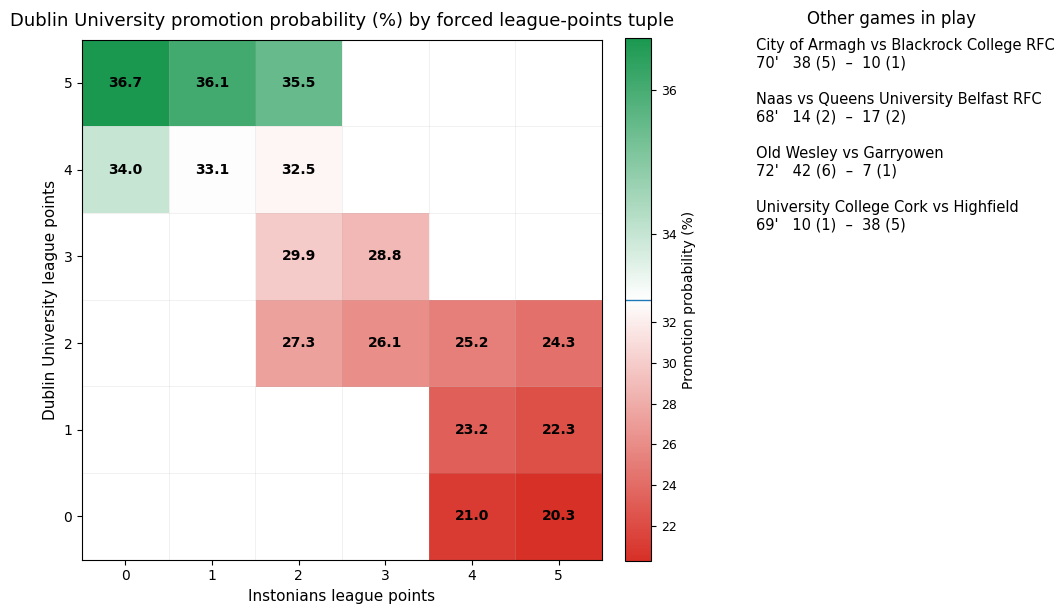

In [57]:
def plot_lp_heatmap_pretty(
    res_df: pd.DataFrame,
    *,
    games: list[tuple[str, str]],
    home_scores: list[int],
    away_scores: list[int],
    home_tries: list[int],
    away_tries: list[int],
    game_times: list[float],              # NEW: minutes elapsed
    baseline_prob: float | None = None,   # e.g. 0.330907
    title: str = "Dublin University promotion probability (%) by forced league-points tuple",
):
    # ---- grid ----
    grid = np.full((6, 6), np.nan, dtype=float)
    for r in res_df.itertuples(index=False):
        grid[int(r.lp_du), int(r.lp_opp)] = 100.0 * float(r.promo_prob)

    vals = grid[np.isfinite(grid)]
    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals))
    center = 100.0 * float(baseline_prob) if baseline_prob is not None else float(np.nanmedian(vals))
    if center <= vmin: vmin = center - 1e-6
    if center >= vmax: vmax = center + 1e-6

    # ---- nicer diverging palette + norm ----
    cmap = LinearSegmentedColormap.from_list("rwg", ["#d73027", "#ffffff", "#1a9850"], N=256)
    norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

    # ---- figure ----
    fig = plt.figure(figsize=(12.2, 6.8))
    gs = fig.add_gridspec(1, 2, width_ratios=[3.25, 1.55], wspace=0.25)

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(grid, origin="lower", cmap=cmap, norm=norm)

    ax.set_xticks(range(6))
    ax.set_yticks(range(6))
    ax.set_xlabel("Instonians league points", fontsize=11)
    ax.set_ylabel("Dublin University league points", fontsize=11)
    ax.set_title(title, fontsize=13, pad=10)

    # subtle gridlines
    ax.set_xticks(np.arange(-.5, 6, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 6, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.25)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.tick_params(labelsize=10)

    # numbers inside cells (nicer font)
    for y in range(6):
        for x in range(6):
            if np.isfinite(grid[y, x]):
                ax.text(x, y, f"{grid[y, x]:.1f}", ha="center", va="center", fontsize=10, fontweight="semibold")

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Promotion probability (%)", fontsize=10)
    cbar.ax.tick_params(labelsize=9)
    if baseline_prob is not None:
        cbar.ax.axhline(center, linewidth=1)

    # ---- right panel: other games ----
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis("off")
    ax2.set_title("Other games in play", fontsize=12, pad=10)

    def pretty_name(t: str) -> str:
        return t.replace("_2526", "")

    def fmt_time(m: float) -> str:
        m = float(m)
        return f"{int(round(m)):02d}'"

    lines = []
    for (home, away), hs, ht, a_s, a_t, tm in zip(
        games, home_scores, home_tries, away_scores, away_tries, game_times
    ):
        lines.append(f"{pretty_name(home)} vs {pretty_name(away)}")
        lines.append(f"{fmt_time(tm)}   {hs} ({ht})  –  {a_s} ({a_t})")
        lines.append("")

    ax2.text(
        0.0, 1.0,
        "\n".join(lines).strip(),
        va="top", ha="left",
        fontsize=10.5,
        family="DejaVu Sans",   # nicer than monospace
        linespacing=1.25
    )

    plt.show()

plot_lp_heatmap_pretty(
     res_df,
     games=games,
     home_scores=home_scores, away_scores=away_scores,
     home_tries=home_tries, away_tries=away_tries,
     game_times=game_times,
     baseline_prob=0.330907,
 )